# Weed or Crop?
## Training a deep learning model to identify between images of weed and crop species

This script contains the methods for the final model run for this analysis.

In [1]:
# Mount google drive where files are located
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [78]:
# Set up 
import os
from os import listdir
import keras

from keras import backend as K  
from keras import models
from keras import layers
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import tensorflow as tf
from tensorflow import one_hot
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image

import gc
import glob

from PIL import Image
from imageio import imread

np.random.seed(5)

In [3]:
# Directory where all images are located
listdir('/content/drive/MyDrive/Harper/3-C7082/Assignment/C7082-assignment/new-data')

['train', 'validation', 'test']

In [4]:
# Define directories for training, validation and test images
base_path = '/content/drive/MyDrive/Harper/3-C7082/Assignment/C7082-assignment/new-data'

train_data_path = os.path.join(base_path, 'train/')
val_data_path = os.path.join(base_path, 'validation/')
test_data_path = os.path.join(base_path, 'test/')


In [5]:
# Create object containing the list of species that make up the classes
species = listdir(train_data_path)
# And print to check they are all there!
print(species)

['bgs', 'chk', 'cls', 'cwd', 'cbl', 'wht', 'fhn', 'lsb', 'mze', 'smw', 'shp', 'sbt']


# Looking at the Images

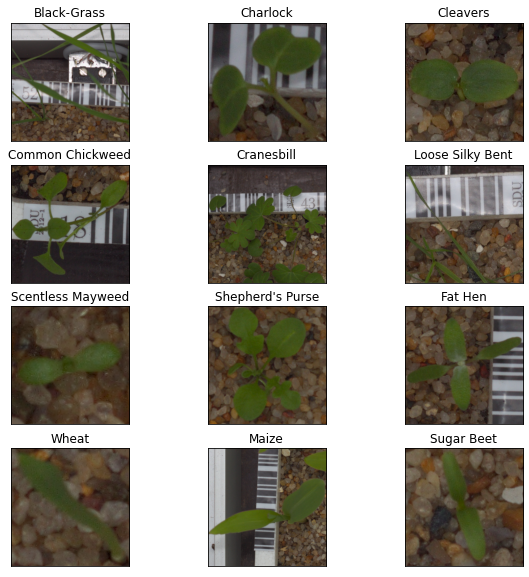

In [104]:
from PIL import Image

fig = plt.figure(figsize=(10, 10))
# Image 1 - Black Grass
im1 = fig.add_subplot(4, 3, 1)
im1.set_title("Black-Grass")
im1.set_xticks([])
im1.set_yticks([])
pil_img = Image.open(os.path.join( train_data_path, 'bgs', 'bgs_6.png'))
im1.imshow(pil_img)
# Image 2 - Chickweed
im2 = fig.add_subplot(4, 3, 2)
im2.set_title("Charlock")
im2.set_xticks([])
im2.set_yticks([])
pil_img = Image.open(os.path.join(train_data_path, 'chk', 'chk_3.png'))
im2.imshow(pil_img)
# Image 3 - Cleavers
im3 = fig.add_subplot(4, 3, 3)
im3.set_title("Cleavers")
im3.set_xticks([])
im3.set_yticks([])
pil_img = Image.open(os.path.join(train_data_path, 'cls', 'cls_3.png'))
im3.imshow(pil_img)

im4 = fig.add_subplot(4, 3, 4)
im4.set_title("Common Chickweed")
im4.set_xticks([])
im4.set_yticks([])
pil_img = Image.open(os.path.join(train_data_path, 'cwd', 'cwd_3.png'))
im4.imshow(pil_img)

im5 = fig.add_subplot(4, 3, 5)
im5.set_title("Cranesbill")
im5.set_xticks([])
im5.set_yticks([])
pil_img = Image.open(os.path.join(train_data_path, 'cbl', 'cbl_3.png'))
im5.imshow(pil_img)

im6 = fig.add_subplot(4, 3, 6)
im6.set_title("Loose Silky Bent")
im6.set_xticks([])
im6.set_yticks([])
pil_img = Image.open(os.path.join(train_data_path, 'lsb', 'lsb_3.png'))
im6.imshow(pil_img)

im7 = fig.add_subplot(4, 3, 7)
im7.set_title("Scentless Mayweed")
im7.set_xticks([])
im7.set_yticks([])
pil_img = Image.open(os.path.join(train_data_path, 'smw', 'smw_3.png'))
im7.imshow(pil_img)

im8 = fig.add_subplot(4, 3, 8)
im8.set_title("Shepherd's Purse")
im8.set_xticks([])
im8.set_yticks([])
pil_img = Image.open(os.path.join(train_data_path, 'shp', 'shp_3.png'))
im8.imshow(pil_img)

im9 = fig.add_subplot(4, 3, 9)
im9.set_title("Fat Hen")
im9.set_xticks([])
im9.set_yticks([])
pil_img = Image.open(os.path.join(train_data_path, 'fhn', 'fhn_3.png'))
im9.imshow(pil_img)

im10 = fig.add_subplot(4, 3, 10)
im10.set_title("Wheat")
im10.set_xticks([])
im10.set_yticks([])
pil_img = Image.open(os.path.join(train_data_path, 'wht', 'wht_4.png'))
im10.imshow(pil_img)

im11 = fig.add_subplot(4, 3, 11)
im11.set_title("Maize")
im11.set_xticks([])
im11.set_yticks([])
pil_img = Image.open(os.path.join(train_data_path, 'mze', 'mze_3.png'))
im11.imshow(pil_img)

im12 = fig.add_subplot(4, 3, 12)
im12.set_title("Sugar Beet")
im12.set_xticks([])
im12.set_yticks([])
pil_img = Image.open(os.path.join(train_data_path, 'sbt', 'sbt_3.png'))
im12.imshow(pil_img)

fig.savefig("saved_images.jpg", bbox_inches='tight')

# Model Creation

In [6]:
# Creation of callbacks
# reduce_lr adjusts the learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', # monitor validation loss for improvements
    factor = 0.5, # the factor that the learning rate will be multiplied by to decrease it
    patience = 3, # after 3 epochs the learning rate will be decreased
    min_lr = 0.0005, # the minimum learning rate that the model can go to
    verbose = 1) # set verbose to 1 so its visible

# early_stop stops training early if no improvements are seen
early_stop = tf.keras.callbacks.EarlyStopping(
              monitor = 'val_loss', # also monitor validation loss for improvements
              patience = 10, # patience of 10 epochs before early stopping
              verbose = 1) # make visible

In [7]:
# Rescale images and apply data augmentations
train_datagen = ImageDataGenerator(
      rescale = 1/255, # this rescales the images so the values are between 0 and 1
      horizontal_flip = True, 
      vertical_flip = True,
      brightness_range = [0.5, 1.5]) # darkens or lightens the image each way by 50%

val_datagen = ImageDataGenerator(
    rescale = 1/255, 
      horizontal_flip = True, 
      vertical_flip = True,
      brightness_range = [0.5, 1.5])

# Do not apply data augmentation to test images
test_datagen = ImageDataGenerator(
    rescale = 1/255
)

In [8]:
# Generate images for model
print("Total images in training data set:")
train_generator = train_datagen.flow_from_directory(
    train_data_path, # path where training data is located
    target_size = (299, 299), # image size
    color_mode = "rgb", # tells it there are three channels for rgb images
    classes = species, # list of 12 classes
    class_mode = "categorical", 
    batch_size = 64,
    shuffle = True,
    seed = 42
)

# same as above for validation data
print("Total images in validation data set")
val_generator = val_datagen.flow_from_directory(
    val_data_path,
    target_size = (299, 299),
    color_mode = "rgb",
    classes = species,
    class_mode = "categorical",
    batch_size = 64,
    shuffle = True,
    seed = 42
)

# Test data
print("Total images in test data set")
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size = (299, 299),
    color_mode = "rgb",
    classes = species,
    class_mode = "categorical",
    batch_size = 1, # only change here is batch size down to 1
    shuffle = True,
    seed = 42
)

Total images in training data set:
Found 4939 images belonging to 12 classes.
Total images in validation data set
Found 300 images belonging to 12 classes.
Total images in test data set
Found 300 images belonging to 12 classes.


In [9]:
# define pretrained Xception base
pretrained_base = xception.Xception(input_shape=[299, 299, 3], # this size should match above size
                                     weights = 'imagenet', # use weights from imagenet
                                     include_top = False) # exclude top as a new one is created below
pretrained_base.trainable = False # freeze the base layers

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
pretrained_base.summary() # 14 blocks of layers in the base

In [11]:
# Create full model with new densely connected classifier
model = tf.keras.Sequential([
    pretrained_base, # this is the pretrained Xception base from above 
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(256, activation = "relu"),
    tf.keras.layers.BatchNormalization(trainable = True, axis = -1),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.BatchNormalization(trainable = True, axis = -1),

    tf.keras.layers.Dense(12, activation = 'softmax') # this should be number of classes, so 12
])

In [12]:
# Compile model with optimiser, loss and metrics
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.005),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

In [13]:
# Fit the model using the training data
result = model.fit(train_generator,
                    epochs = 50,
                    verbose = 1, # so progress can be viewed
                    validation_data = val_generator,
                    callbacks = [reduce_lr, early_stop])

Epoch 1/50
78/78 [==============================] - 1406s 18s/step - loss: 1.6329 - accuracy: 0.4857 - val_loss: 1.8675 - val_accuracy: 0.5167
Epoch 2/50
78/78 [==============================] - 78s 1s/step - loss: 0.7363 - accuracy: 0.7440 - val_loss: 1.2004 - val_accuracy: 0.6500
Epoch 3/50
78/78 [==============================] - 77s 988ms/step - loss: 0.6508 - accuracy: 0.7780 - val_loss: 0.5334 - val_accuracy: 0.7833
Epoch 4/50
78/78 [==============================] - 76s 966ms/step - loss: 0.5478 - accuracy: 0.8107 - val_loss: 0.6466 - val_accuracy: 0.7367
Epoch 5/50
78/78 [==============================] - 74s 949ms/step - loss: 0.5037 - accuracy: 0.8188 - val_loss: 0.5818 - val_accuracy: 0.7967
Epoch 6/50
78/78 [==============================] - 75s 953ms/step - loss: 0.4801 - accuracy: 0.8213 - val_loss: 0.6429 - val_accuracy: 0.7767

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 7/50
78/78 [==============================] - 74s 943ms/st

In [116]:
print('Maximum Training Accuracy:')
max(result.history['accuracy'])

Maximum Training Accuracy:


0.9327799081802368

In [117]:
print('Maximum Validation Accuracy:')
max(result.history['val_accuracy'])

Maximum Validation Accuracy:


0.8933333158493042

In [118]:
print('Minimum Training Loss:')
min(result.history['loss'])

Minimum Training Loss:


0.18576353788375854

In [119]:
print('Minimum Validation Loss:')
min(result.history['val_loss'])

Minimum Validation Loss:


0.3685705065727234

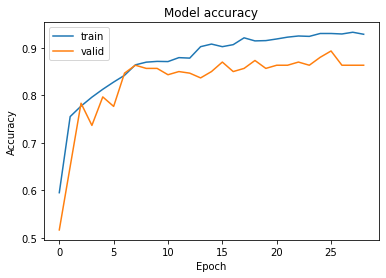

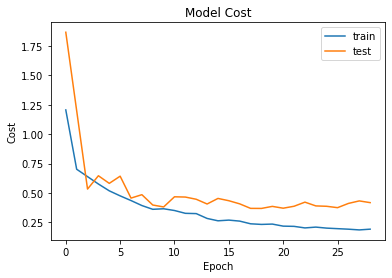

In [14]:
# Create plot for training and validation accuracy
plt.plot(result.history['accuracy'], label = 'train') # one line for training data
plt.plot(result.history['val_accuracy'], label = 'valid') # one line for validation data
plt.legend(loc = 'upper left') # add a ledgend
plt.title('Model accuracy') # title
plt.ylabel('Accuracy') # y axis label
plt.xlabel('Epoch') # x axis label
plt.show() # show plot

# Create plot for training and validation loss
plt.plot(result.history['loss'], label = 'train')
plt.plot(result.history['val_loss'], label = 'test')
plt.legend(loc = 'upper right')
plt.title('Model Cost')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

In [16]:
from keras.models import load_model
model.save('final_model.h5') # save model

# Testing the Model

In [17]:
# Run unseen test dataset through the model
test_evaluate = model.evaluate(test_generator)

300/300 [==============================] - 84s 280ms/step - loss: 0.4642 - accuracy: 0.8767


In [18]:
print('Test Loss:', test_evaluate[0])
print('Test Accuracy:', test_evaluate[1])

Test Loss: 0.4641658067703247
Test Accuracy: 0.8766666650772095


Accuracy is shown as being 88%, however accuracy is not always the best measure of success, especially when there is an imbalance in classes.

In [28]:
# Make predictions on this test data
predictions = model.predict(test_generator)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

In [29]:
true_classes = test_generator.classes #these are the correct classes for images in the test set
class_labels = list(test_generator.class_indices.keys())  

In [32]:
from sklearn import metrics
# Create classification report
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

              precision    recall  f1-score   support

         bgs       0.05      0.04      0.05        25
         chk       0.13      0.12      0.12        25
         cls       0.12      0.12      0.12        25
         cwd       0.00      0.00      0.00        25
         cbl       0.09      0.08      0.08        25
         wht       0.00      0.00      0.00        25
         fhn       0.12      0.12      0.12        25
         lsb       0.07      0.08      0.07        25
         mze       0.17      0.16      0.16        25
         smw       0.13      0.16      0.15        25
         shp       0.10      0.08      0.09        25
         sbt       0.19      0.20      0.19        25

    accuracy                           0.10       300
   macro avg       0.10      0.10      0.10       300
weighted avg       0.10      0.10      0.10       300



Classification report shows that the precision and recall of the model are much lower.

It is also clear that different classes have different precision scores, with Sugar Beet and Maize performing much higher than the rest.

The precision of wheat is 0.00 and black grass is 0.05, the lowest scoring species. These are similar looking and both small thin plants.

# Testing my model on new images


In [22]:
# Define path to new images from GBIF
new_path = '/content/drive/MyDrive/Harper/3-C7082/Assignment/C7082-assignment/GBIF-data'

In [23]:
# Do not apply data augmentation to test images
new_datagen = ImageDataGenerator(
    rescale = 1/255
)

In [24]:
# Generator for new images
print("Total images in test data set")
new_generator = new_datagen.flow_from_directory(
    new_path,
    target_size = (299, 299),
    color_mode = "rgb",
    classes = species,
    class_mode = "categorical",
    batch_size = 1,
    shuffle = True,
    seed = 42
)

Total images in test data set
Found 290 images belonging to 12 classes.


In [25]:
# Evaluate the final model on this new set of images
new_evaluate = model.evaluate(new_generator)

290/290 [==============================] - 76s 263ms/step - loss: 5.5369 - accuracy: 0.2310


In [26]:
# Get loss and accuracy for this new data
print('New Data Loss:', new_evaluate[0])
print('New Accuracy:', new_evaluate[1])

New Data Loss: 5.536899089813232
New Accuracy: 0.23103448748588562


In [34]:
new_predictions = model.predict(new_generator)
# Get most likely class
new_predicted_classes = np.argmax(new_predictions, axis=1)

In [35]:
new_true_classes = new_generator.classes #these are the correct classes for images in the test set
new_class_labels = list(new_generator.class_indices.keys())  

In [36]:
from sklearn import metrics
new_report = metrics.classification_report(new_true_classes, 
                                           new_predicted_classes, 
                                           target_names = new_class_labels)
print(new_report) 

              precision    recall  f1-score   support

         bgs       0.00      0.00      0.00        20
         chk       0.15      0.28      0.19        25
         cls       1.00      0.04      0.08        25
         cwd       0.00      0.00      0.00        25
         cbl       0.05      0.08      0.06        25
         wht       0.08      0.05      0.06        20
         fhn       0.16      0.20      0.18        25
         lsb       0.07      0.24      0.11        25
         mze       0.10      0.16      0.12        25
         smw       0.00      0.00      0.00        25
         shp       0.00      0.00      0.00        25
         sbt       0.00      0.00      0.00        25

    accuracy                           0.09       290
   macro avg       0.13      0.09      0.07       290
weighted avg       0.14      0.09      0.07       290



# Visualising what the model is learning

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               5

In [39]:
img_path = '/content/drive/MyDrive/Harper/3-C7082/Assignment/C7082-assignment/new-data/train/sbt/sbt_1.png'

In [40]:
from keras.preprocessing import image

img = image.load_img(img_path, target_size=(299, 299))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 299, 299, 3)


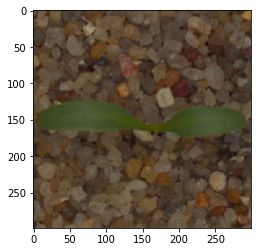

In [41]:
plt.imshow(img_tensor[0])
plt.show()

In [57]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:]]

activation_model = models.Model(inputs = model.get_layer('xception').inputs,
                          outputs = model.get_layer('xception').get_layer('block14_sepconv2_act').output)


In [58]:
activations = activation_model.predict(img_tensor)

In [59]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)
# 10 by 10 feature map with 2048 channels

(10, 10, 2048)


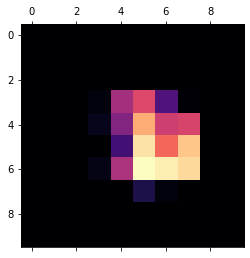

In [74]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[:, :, 1], cmap='magma')
plt.show()

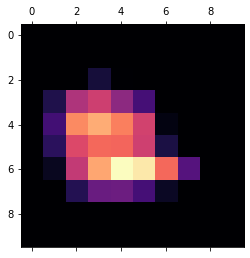

In [77]:
plt.matshow(first_layer_activation[ :, :, 100], cmap='magma')
plt.show()